In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.model_selection import KFold

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 修改中文字體
plt.rcParams['axes.unicode_minus'] = False # 顯示負號

# set device to gpu
device = (
"cuda"
if torch.cuda.is_available()
else "mps"
if torch.backends.mps.is_available()
else "cpu"
)
device

'mps'

In [2]:
tfidf_all_data = pd.read_csv('../Data/all_tfidf_vector.csv')
tfidf_all_data['source'] = tfidf_all_data['source'].apply(lambda x: 1 if x == 'ptt' else 0)
tfidf_all_data.set_index('Unnamed: 0', inplace=True)
tfidf_all_data.index.name = None

word2vec_all_data = pd.read_csv('../Data/all_word2vec_vector.csv')
word2vec_all_data['source'] = word2vec_all_data['source'].apply(lambda x: 1 if x == 'ptt' else 0)
word2vec_all_data.set_index('Unnamed: 0', inplace=True)
word2vec_all_data.index.name = None

bert_all_data = pd.read_csv('../Data/all_bert_vector.csv')
bert_all_data['source'] = bert_all_data['source'].apply(lambda x: 1 if x == 'ptt' else 0)

In [3]:
def train_mlp_model(df, model_path, scaler_path):
    data = df.copy()
    y = data.pop('source')  # 假设标签列名为 'source'

    # 标准化数据
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data.values)
    # 保存标准化器
    joblib.dump(scaler, scaler_path)

    # 10折交叉验证
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold = 0
    confusion_matrices = []
    best_model = None
    best_val_loss = float('inf')

    for train_index, test_index in kf.split(X_scaled):
        fold += 1
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # 将数据转换为 PyTorch 张量并移动到 GPU
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

        # 建立 MLP 模型
        input_size = X_train_tensor.shape[1]
        model = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        ).to(device)

        # 定义损失函数和优化器
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # 训练模型
        num_epochs = 100
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 10 == 0:
                print(f'Fold [{fold}], Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # 测试模型并计算验证损失
        model.eval()
        with torch.no_grad():
            y_pred_test = model(X_test_tensor)
            val_loss = criterion(y_pred_test, y_test_tensor).item()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model

            y_pred_train = model(X_train_tensor).cpu().numpy()
            y_pred_test = y_pred_test.cpu().numpy()

            y_pred_train = (y_pred_train > 0.5).astype(int)
            y_pred_test = (y_pred_test > 0.5).astype(int)

            y_train_numpy = y_train_tensor.cpu().numpy()
            y_test_numpy = y_test_tensor.cpu().numpy()

            cm_train = confusion_matrix(y_train_numpy, y_pred_train)
            cm_test = confusion_matrix(y_test_numpy, y_pred_test)
            confusion_matrices.append((cm_train, cm_test))

    num_folds = len(confusion_matrices)

    fig, axs = plt.subplots(num_folds, 2, figsize=(20, num_folds * 5))
    fig.suptitle('Confusion Matrices for 10-Fold Cross Validation')

    for i, (cm_train, cm_test) in enumerate(confusion_matrices):
        ax_train = axs[i, 0]
        ax_test = axs[i, 1]

        sns.heatmap(cm_train, annot=True, fmt='d', ax=ax_train, cmap='Blues')
        ax_train.set_title(f'Fold {i+1} Train')
        ax_train.set_xlabel('Predicted')
        ax_train.set_ylabel('Actual')

        sns.heatmap(cm_test, annot=True, fmt='d', ax=ax_test, cmap='Blues')
        ax_test.set_title(f'Fold {i+1} Test')
        ax_test.set_xlabel('Predicted')
        ax_test.set_ylabel('Actual')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

    # 保存最佳模型
    torch.save(best_model, model_path)

/Users/jim/anaconda3/envs/forDeepLearning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fold [1], Epoch [10/100], Loss: 8.0582
Fold [1], Epoch [20/100], Loss: 0.4178
Fold [1], Epoch [30/100], Loss: 0.3478
Fold [1], Epoch [40/100], Loss: 0.2730
Fold [1], Epoch [50/100], Loss: 0.1497
Fold [1], Epoch [60/100], Loss: 0.0206
Fold [1], Epoch [70/100], Loss: 0.0009
Fold [1], Epoch [80/100], Loss: 0.0001
Fold [1], Epoch [90/100], Loss: 0.0000
Fold [1], Epoch [100/100], Loss: 0.0000
Fold [2], Epoch [10/100], Loss: 5.2119
Fold [2], Epoch [20/100], Loss: 0.3912
Fold [2], Epoch [30/100], Loss: 0.3515
Fold [2], Epoch [40/100], Loss: 0.2943
Fold [2], Epoch [50/100], Loss: 0.1719
Fold [2], Epoch [60/100], Loss: 0.0200
Fold [2], Epoch [70/100], Loss: 0.0006
Fold [2], Epoch [80/100], Loss: 0.0001
Fold [2], Epoch [90/100], Loss: 0.0000
Fold [2], Epoch [100/100], Loss: 0.0000
Fold [3], Epoch [10/100], Loss: 0.0075
Fold [3], Epoch [20/100], Loss: 0.0000
Fold [3], Epoch [30/100], Loss: 0.0000
Fold [3], Epoch [40/100], Loss: 0.0000
Fold [3], Epoch [50/100], Loss: 0.0000
Fold [3], Epoch [60/100

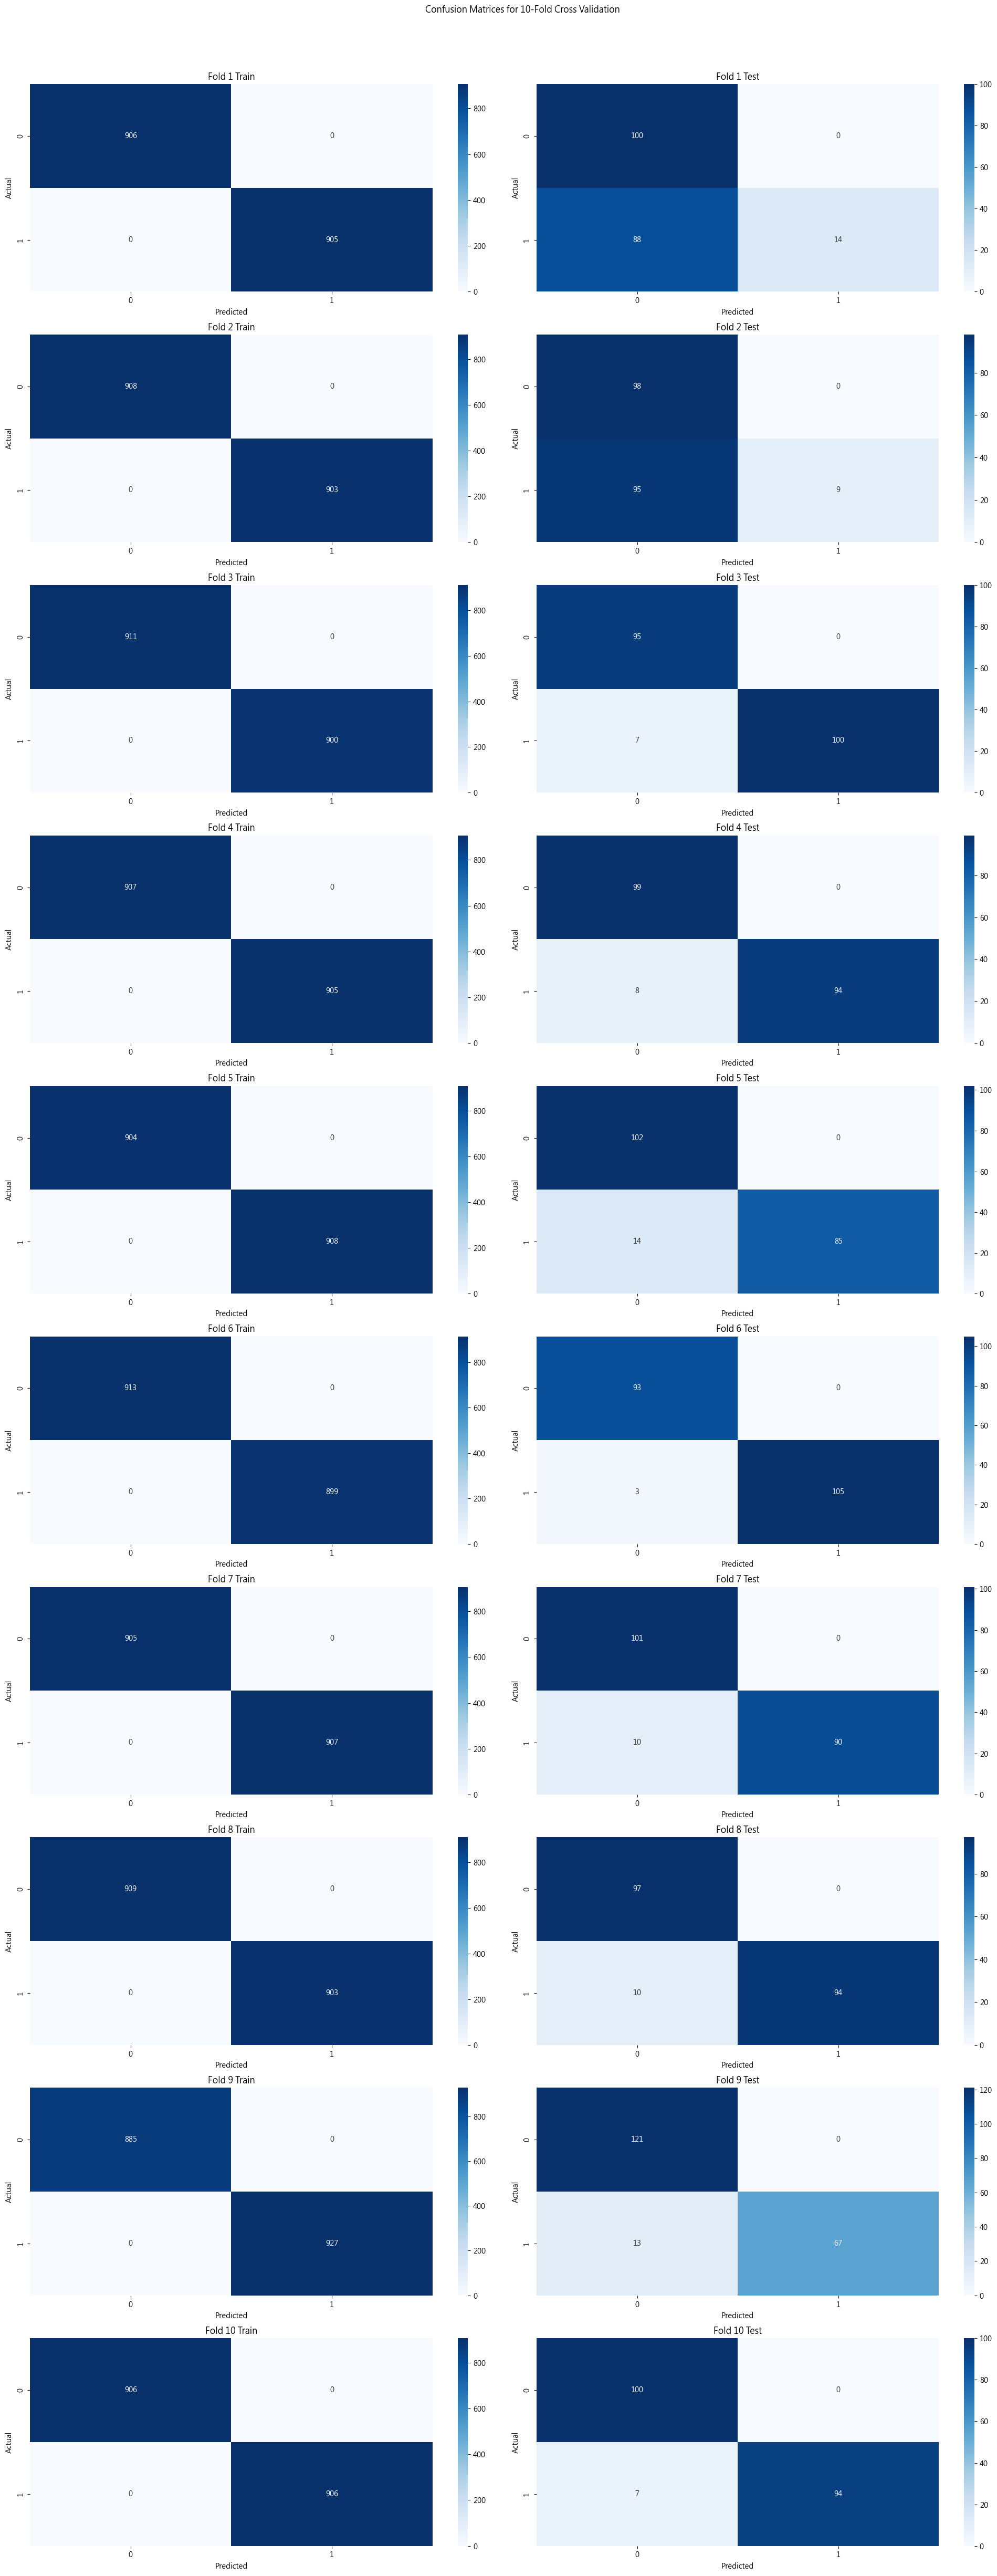

In [4]:
train_mlp_model(tfidf_all_data, '../Data/Model/tfidf_mlp_10fold_model.pth', '../Data/Model/tfidf_10fold_scaler.pkl')

Fold [1], Epoch [10/100], Loss: 0.0651
Fold [1], Epoch [20/100], Loss: 0.0430
Fold [1], Epoch [30/100], Loss: 0.0192
Fold [1], Epoch [40/100], Loss: 0.0198
Fold [1], Epoch [50/100], Loss: 0.0044
Fold [1], Epoch [60/100], Loss: 0.0034
Fold [1], Epoch [70/100], Loss: 0.0010
Fold [1], Epoch [80/100], Loss: 0.0004
Fold [1], Epoch [90/100], Loss: 0.0001
Fold [1], Epoch [100/100], Loss: 0.0001
Fold [2], Epoch [10/100], Loss: 0.0924
Fold [2], Epoch [20/100], Loss: 0.1323
Fold [2], Epoch [30/100], Loss: 0.0348
Fold [2], Epoch [40/100], Loss: 0.0172
Fold [2], Epoch [50/100], Loss: 0.0089
Fold [2], Epoch [60/100], Loss: 0.0049
Fold [2], Epoch [70/100], Loss: 0.0031
Fold [2], Epoch [80/100], Loss: 0.0021
Fold [2], Epoch [90/100], Loss: 0.0014
Fold [2], Epoch [100/100], Loss: 0.0010
Fold [3], Epoch [10/100], Loss: 0.0777
Fold [3], Epoch [20/100], Loss: 0.0490
Fold [3], Epoch [30/100], Loss: 0.1338
Fold [3], Epoch [40/100], Loss: 0.0613
Fold [3], Epoch [50/100], Loss: 0.0228
Fold [3], Epoch [60/100

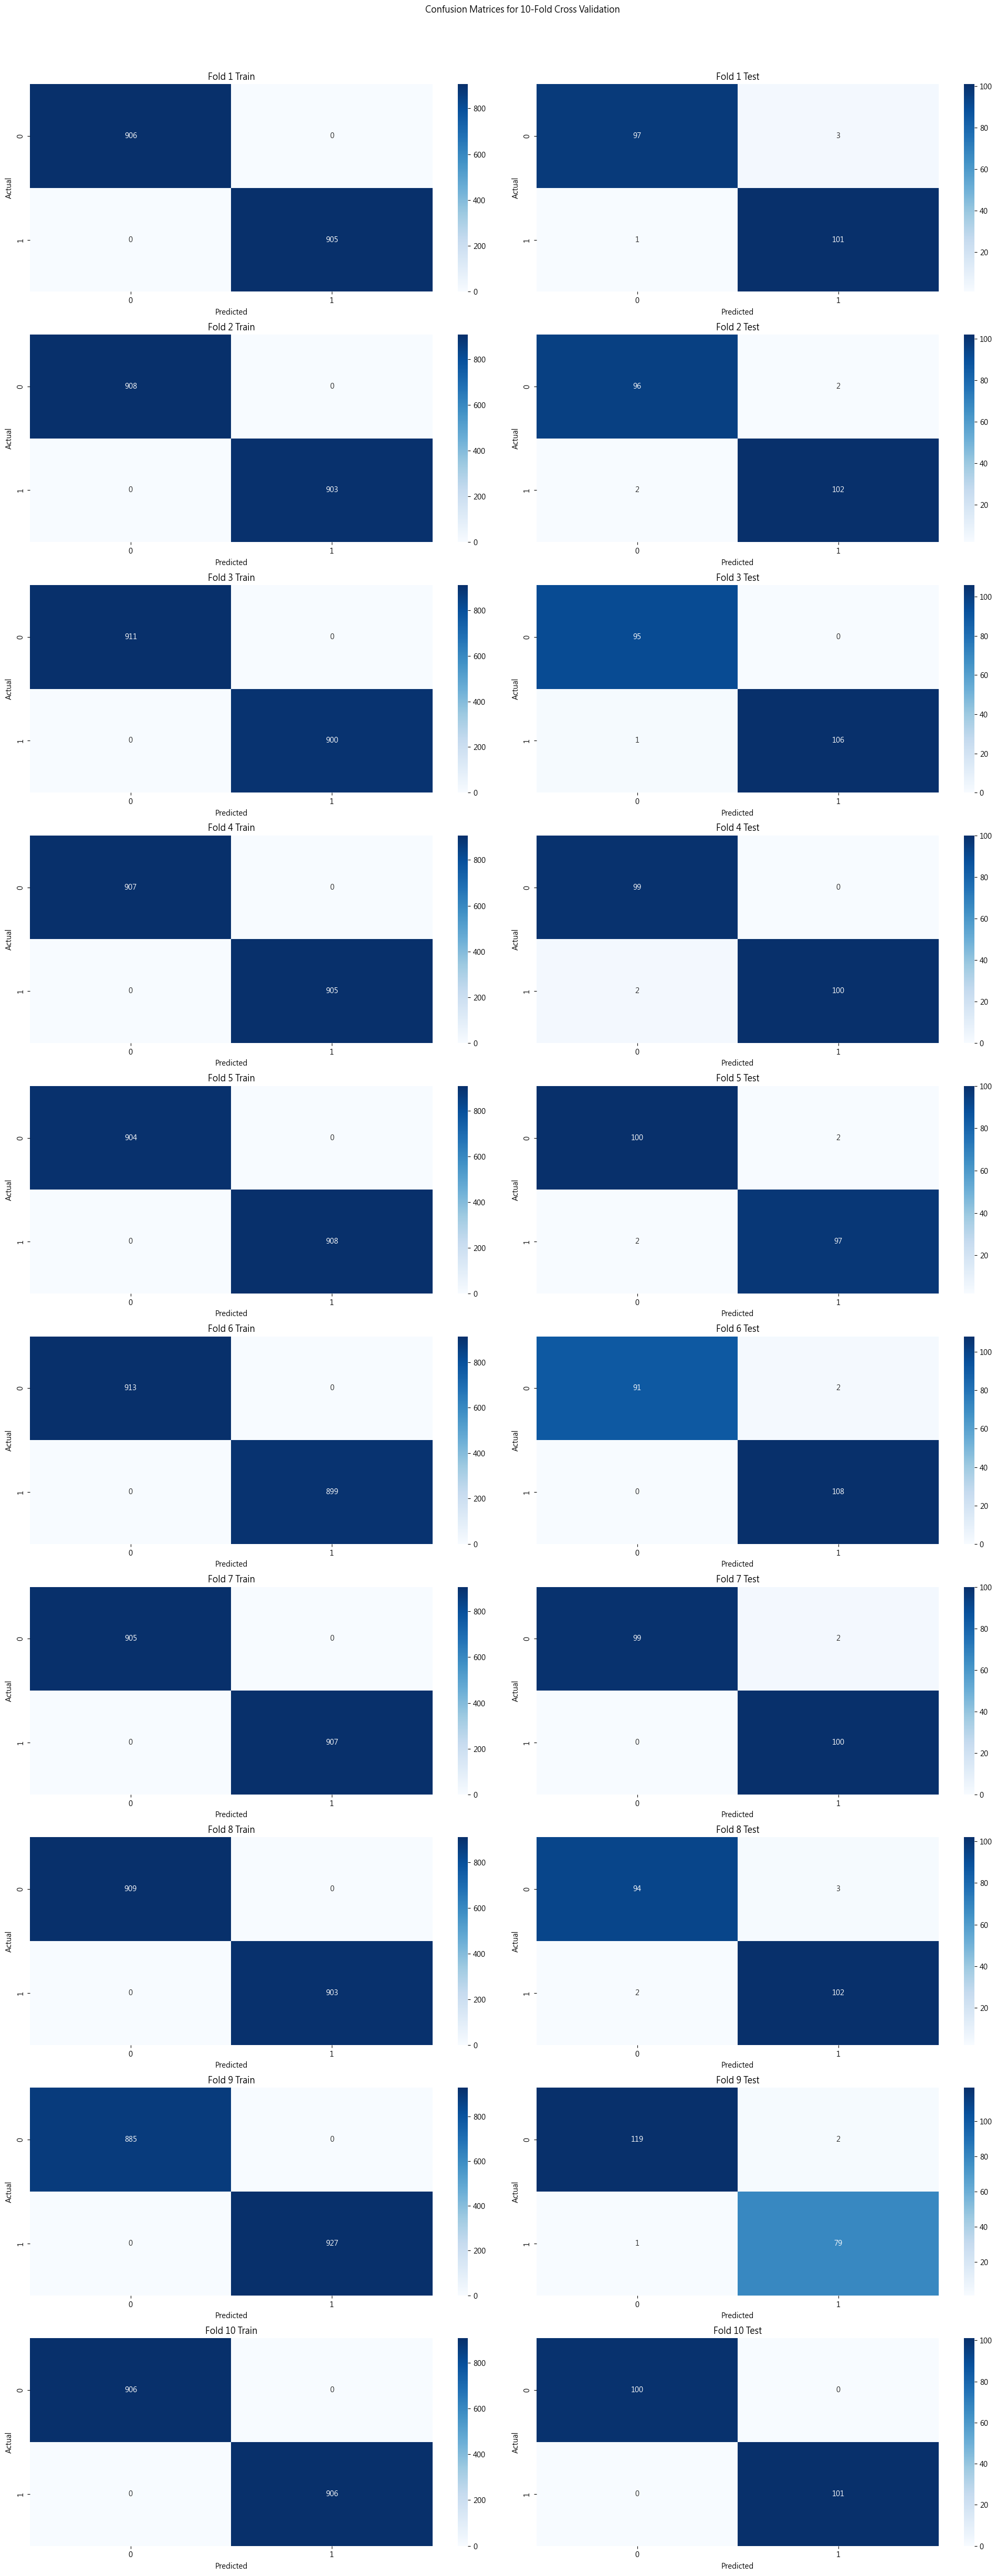

In [5]:
train_mlp_model(word2vec_all_data, '../Data/Model/word2vec_mlp_10fold_model.pth', '../Data/Model/word2vec_10fold_scaler.pkl')

Fold [1], Epoch [10/100], Loss: 0.0049
Fold [1], Epoch [20/100], Loss: 0.0000
Fold [1], Epoch [30/100], Loss: 0.0000
Fold [1], Epoch [40/100], Loss: 0.0000
Fold [1], Epoch [50/100], Loss: 0.0000
Fold [1], Epoch [60/100], Loss: 0.0000
Fold [1], Epoch [70/100], Loss: 0.0000
Fold [1], Epoch [80/100], Loss: 0.0000
Fold [1], Epoch [90/100], Loss: 0.0000
Fold [1], Epoch [100/100], Loss: 0.0000
Fold [2], Epoch [10/100], Loss: 0.0004
Fold [2], Epoch [20/100], Loss: 0.0000
Fold [2], Epoch [30/100], Loss: 0.0000
Fold [2], Epoch [40/100], Loss: 0.0000
Fold [2], Epoch [50/100], Loss: 0.0000
Fold [2], Epoch [60/100], Loss: 0.0000
Fold [2], Epoch [70/100], Loss: 0.0000
Fold [2], Epoch [80/100], Loss: 0.0000
Fold [2], Epoch [90/100], Loss: 0.0000
Fold [2], Epoch [100/100], Loss: 0.0000
Fold [3], Epoch [10/100], Loss: 0.0004
Fold [3], Epoch [20/100], Loss: 0.0000
Fold [3], Epoch [30/100], Loss: 0.0000
Fold [3], Epoch [40/100], Loss: 0.0000
Fold [3], Epoch [50/100], Loss: 0.0000
Fold [3], Epoch [60/100

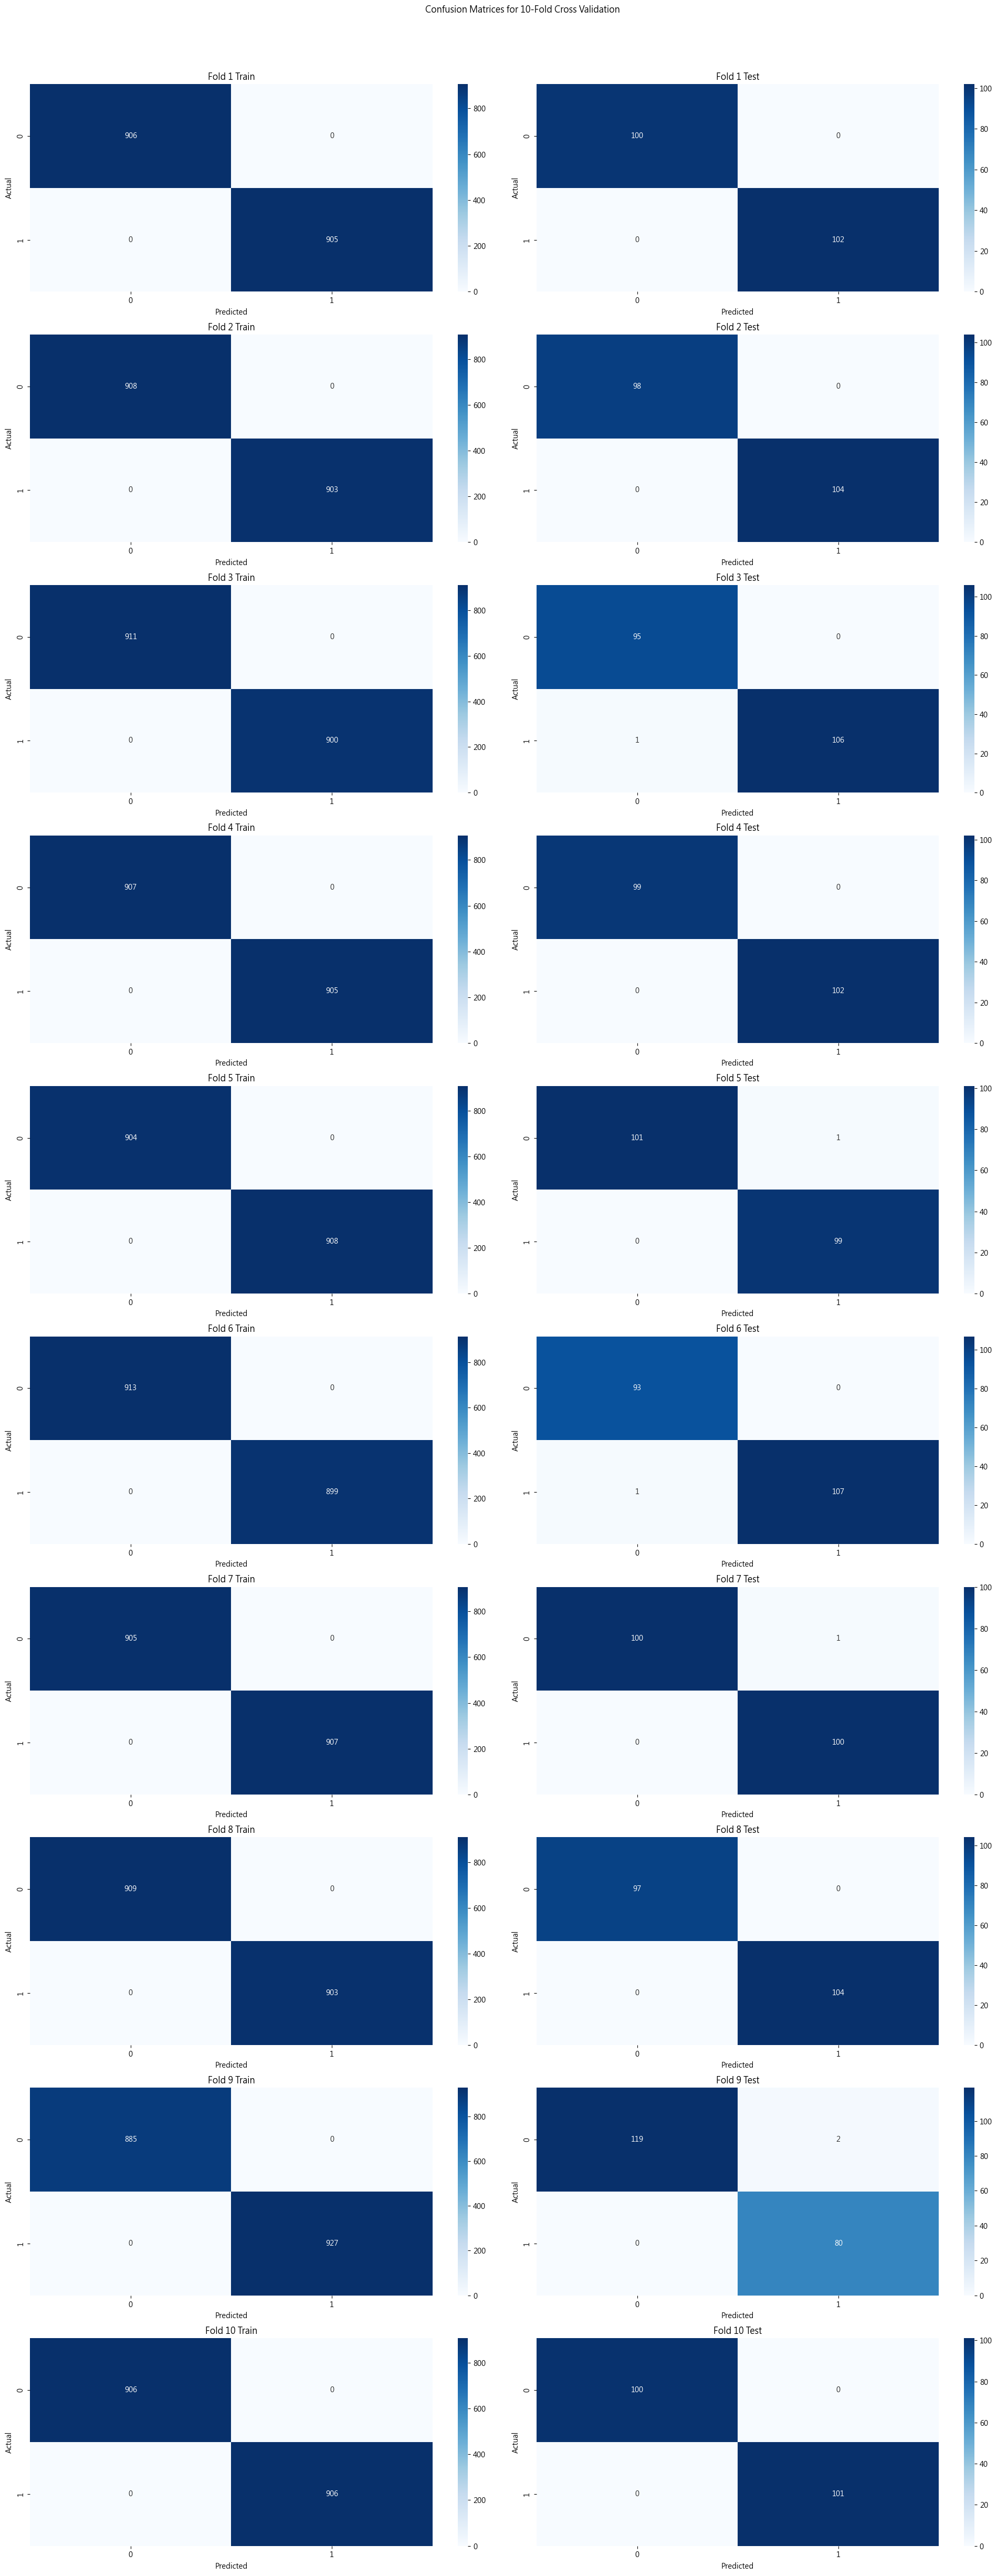

In [6]:
train_mlp_model(bert_all_data, '../Data/Model/bert_mlp_10fold_model.pth', '../Data/Model/bert_10fold_scaler.pkl')